# Project Objective


Microsoft is creating a new movie studio. This project aims to advise Microsoft on what type of movies to produce. More specifically, it presents three actionable recommendations. 

# Recommendations

The three recommendations derived from our analysis are:
    
    1. Adopt the less riskier-larger budget business model (> $90 million)

    2. Exploiting the synergies between Microsoft’s existing assets/capabilities, focus on animation movies
 
    3. Release the movie in a month with large audience numbers but less competition - October


The following is a technical description of the process that is driving these recommendations. 

# Process

### Data Cleaning

We used two sources for our data: Two IMDB and two Movie DB files. IMDB provided basic movie characteristics and ratings while the Movie DB gave budget and revenues along with similarly basic movie characteristics.
We first merged the two files provided by the same source. The IMDB files contained a unique ID for each movie, which became key for the merge. The Movie DB files were merged with the release year-month and movie name used as the key. Movie names had to be processed to eliminate whitespaces and non-alphanumeric characters, and ware converted to uppercase.
Duplicate observations were also dropped.
As the last step, two sets of files were merged using the year and movie name as the joint key. 

In [8]:
%run Movie_Analysis_Functions.py

In [9]:
import Movie_Analysis_Functions # This file contains the functions created for this project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
data_directory = '../Data/' #This will need to be changed to point at where ever you're storing your data.  
df_imdb_basics = pd.read_csv(data_directory+'imdb.title.basics.csv.gz') # Source: IMDB
df_imdb_ratings = pd.read_csv(data_directory+'imdb.title.ratings.csv.gz') # Source: IMDB
df_mdb_ratings = pd.read_csv(data_directory+'tmdb.movies.csv.gz') # Source: MovieDB
df_mdb_revenues = pd.read_csv(data_directory+'tn.movie_budgets.csv.gz') # Source: MovieDB

In [11]:
df_mdb_ratings.drop('Unnamed: 0', axis = 1, inplace = True) # This is an extra index column
df_mdb_ratings = df_clean(df_mdb_ratings, 'release_date', 'title')
df_mdb_revenues = df_clean(df_mdb_revenues, 'release_date', 'movie')
df_mdb = pd.merge(df_mdb_ratings, df_mdb_revenues, how = 'outer', \
              left_on = ['title', 'release_year_month', 'release_year'], \
              right_on = ['title', 'release_year_month', 'release_year'], \
              indicator = True, validate="one_to_one", \
              sort = True)

# Merge IMDB dataframes
df_imdb_basics = df_clean(df_imdb_basics, 'start_year', 'primary_title')
df_imdb = pd.merge(df_imdb_basics, df_imdb_ratings, how = 'outer', \
              on = 'tconst', \
              indicator = True, validate="one_to_one")

# Merge Movie DB and IMDB dataframes
df = pd.merge(df_imdb.drop(columns = '_merge'), df_mdb.drop(columns = '_merge'), how = 'outer', \
              left_on = ['title', 'release_year'], \
              right_on = ['title', 'release_year'], \
              indicator = True, validate="many_to_many", \
              sort = True)
df_merged = df.loc[df._merge == 'both']

# Clean the merged dataframe
df_clean = df.drop(columns = ['tconst', 'original_title_x', 'runtime_minutes', 'id_x', 'original_language', 'original_title_y', 'id_y'])
df_clean_drop = df_clean.loc[(df_clean.numvotes.isna()) & (df_clean.vote_count.isna())]
df_clean = df_clean.drop(df_clean_drop.index)

df_clean.to_csv (data_directory+'export_df_clean.csv', index = None, header=True) 

Additionally, in order to get viewership numbers we looked at the the sum of reviews. Note, this is confusing as it sounds like the sum of ratings, i.e, 10/10 but what we're actually looking at is the number of people who left any kind of review, poor or good, as it demonstrates that they've seen the movie. The top 25% was found using the .descirbe() function and resulted in the dataframe below. 

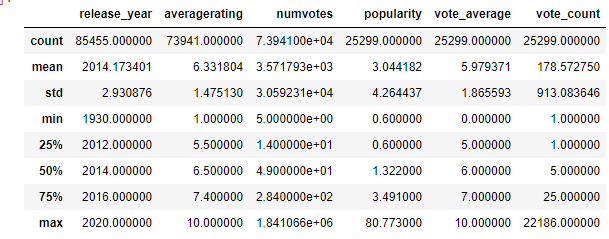

Then, in order to get the most watched movies, we took the top 25%, as that's the kind of movie, a well-viewed, in terms of actually seats filled, movie, that we're looking to make.

In [12]:
df_watched = df_clean.loc[(df_clean["numvotes"] >= 284) & (df_clean["vote_count"] >= 25)]

### Descriptive Analysis

The analysis focuses on two outcome indicators of interest: return on investment and audience numbers. For the first, we use log difference between the worldwide gross revenues and production budget to reduce dispersion. For the second, we use number of votes for the IMDB ratings. We prefer to use the IMDB ratings as the movie coverage is larger compared to the Movie DB ratings.
We link these outcome indicators to three movie characteristics: budget, release month, and genre. Budget refers to the production budget in log terms, similarly to reduce dispersion. The release month is extracted from release date (available only for the Movie DB data). The genre analysis does not classify each movie strictly under a genre. If a movie is classifed under multiple genres such as animation and comedy, the same movie will appear under both the list for animation movies and the list for comedy movies.
In exploring the links between budget and return on investment, outliers in the budget and revenue series are identified using the standard Q1-1.5IQR, Q3+1.5IQR formula. These outliers, for the time being, are dropped and will be subject to further analysis.  

In [13]:
data_directory = '../Data/' 
import Movie_Analysis_Functions # This file contains the functions created for this project.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df_clean = pd.read_csv(data_directory+'export_df_clean.csv')
df_budget = df_clean.loc[(df_clean.production_budget.isna() == False) & \
                         (df_clean.domestic_gross.isna() == False) & \
                         (df_clean.worldwide_gross.isna() == False)]
# Convert budget and revenues to int and log terms using 
# clean_dollar_values function from Movie_Analysis_Functions Python file.
for series_name in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    df_budget = clean_dollar_values(df_budget, series_name)
df_budget['budget'] = np.log(df_budget.production_budget_int)
df_budget['domestic_revenues'] = np.log(df_budget.domestic_gross_int)
df_budget['world_revenues'] = np.log(df_budget.worldwide_gross_int)

C:\Users\BudBe\Repositories\fis_dsi\FIS-Mod1-Project\Movie_Analysis_Functions.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for item in data_frame[series_name]]
C:\Users\BudBe\Repositories\fis_dsi\FIS-Mod1-Project\Movie_Analysis_Functions.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for item in data_frame[series_name+'_int']]
C:\Users\BudBe\Repositories\fis_dsi\FIS-Mod1-Project\Movie_Analysis_Functions.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

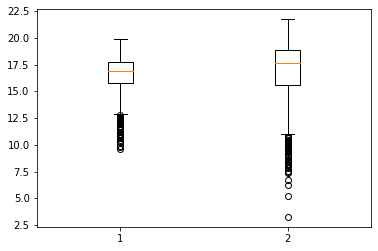

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [15]:
# Clean out outliers in budget and worldwide revenue series using
# calculate_whiskers function from Movie_Analysis_Functions Python file.
plt.boxplot([df_budget.budget, df_budget.world_revenues])
plt.set_xticklabels = [(1, 'Budget'), (2, 'Worldwide revenues')]
plt.show()
df_budget['budget_outliers'] = df_budget.loc[(df_budget.budget < calculate_whiskers(df_budget.budget)[0]) | \
                                             (df_budget.budget > calculate_whiskers(df_budget.budget)[1])].budget
df_budget = df_budget.loc[df_budget.budget_outliers.isna()]
df_budget['world_revenues_outliers'] = df_budget.loc[(df_budget.world_revenues < calculate_whiskers(df_budget.world_revenues)[0]) | \
                                                     (df_budget.world_revenues > calculate_whiskers(df_budget.world_revenues)[1])].world_revenues
df_budget = df_budget.loc[df_budget.world_revenues_outliers.isna()]

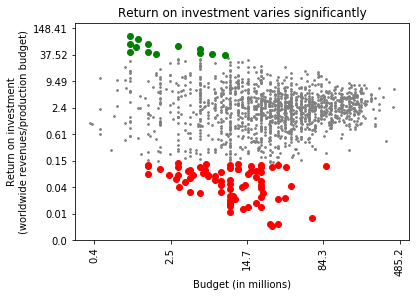

In [16]:
# Show outliers for ROI
df_budget['roi'] = df_budget.world_revenues - df_budget.budget 
df_budget['roi_bottom'] = df_budget.loc[(df_budget.roi < calculate_whiskers(df_budget.roi)[0])].roi
df_budget['roi_top'] = df_budget.loc[(df_budget.roi > calculate_whiskers(df_budget.roi)[1])].roi
df_budget_roi_top = df_budget.loc[df_budget.roi_top.isna() == False]
df_budget_roi_bottom = df_budget.loc[df_budget.roi_bottom.isna() == False]
plt.scatter(df_budget.budget, df_budget.roi, color = 'grey', s = 3) 
plt.scatter(df_budget.budget, df_budget.roi_bottom, color = 'r') 
plt.scatter(df_budget.budget, df_budget.roi_top, color = 'g')
plt.xticks(np.arange(13, 20+(20-13)/4, (20-13)/4), (np.exp(np.arange(13, 20+(20-13)/4, (20-13)/4))*(10**(-6))).round(1), rotation = 90)
plt.xlabel('Budget (in millions)')
plt.yticks(np.arange(-6, 5+(5-(-6))/8, (5-(-6))/8), np.exp(np.arange(-6, 5+(5-(-6))/8, (5-(-6))/8)).round(2))
plt.ylabel('Return on investment\n(worldwide revenues/production budget)')
plt.title('Return on investment varies significantly')
plt.show()

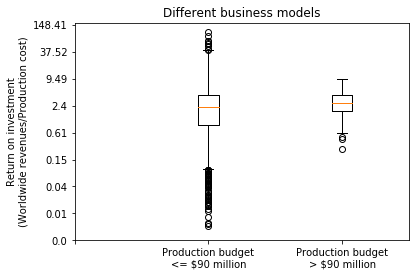

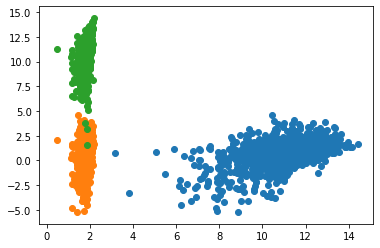

In [18]:
# Show ROI dispersion for <> $90 million movies
boxplot_data = [df_budget.loc[df_budget.production_budget_int <= 90*(10**6)].roi, \
                df_budget.loc[df_budget.production_budget_int > 90*(10**6)].roi]
plt.boxplot(boxplot_data)
plt.ylabel('Return on investment\n(Worldwide revenues/Production cost)')
plt.yticks(np.arange(-6, 5+(5-(-6))/8, (5-(-6))/8), \
           np.exp(np.arange(-6, 5+(5-(-6))/8, (5-(-6))/8)).round(2))
plt.xticks(np.arange(3), ('','Production budget\n<= $90 million', 'Production budget\n> $90 million'))
plt.title('Different business models')
plt.show()
lp_large = df_budget.loc[(df_budget.production_budget_int > 90*(10**6)) & (df_budget.roi < 0)] 
lp_small = df_budget.loc[(df_budget.production_budget_int <= 90*(10**6)) & (df_budget.roi < 0)]
# Show if there is a relationship between ROI and ratings
plt.scatter(np.log(df_budget.numvotes), df_budget.roi)
plt.scatter(np.log(df_budget.averagerating), df_budget.roi)
plt.scatter(np.log(df_budget.averagerating), np.log(df_budget.numvotes))

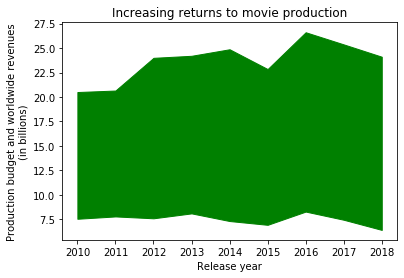

ValueError: x and y must have same first dimension, but have shapes (87489,) and (9,)

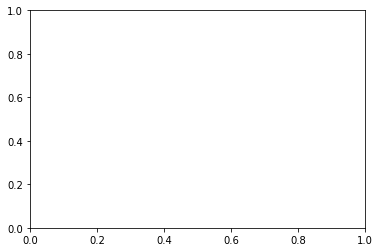

In [19]:
# Prepare descriptive stats at the industry level
df_budget_annual_sum = df_budget.loc[(df_budget.release_year >=2010) & \
                                     (df_budget.release_year <= 2018)]. \
                                     groupby(['release_year']). \
                                     sum()
plt.fill_between(df_budget_annual_sum.index, \
                 (df_budget_annual_sum.production_budget_int)*(10**(-9)), \
                 (df_budget_annual_sum.worldwide_gross_int)*(10**(-9)), \
                 color='g')
plt.xlabel('Release year')
plt.ylabel('Production budget and worldwide revenues\n(in billions)')
plt.title('Increasing returns to movie production')
plt.show()
df_clean_annual_count = df_clean.loc[(df_clean.release_year >=2010) & \
                                     (df_clean.release_year <= 2018)]. \
                                     groupby(['release_year']). \
                                     title.count() 
plt.plot(df_clean.release_year, df_clean_annual_count)

We also wanted to find out a movie of certain genre are likely to be released. The easiest example is that "horror" movies see peek release in October, in coordination with Halloween.

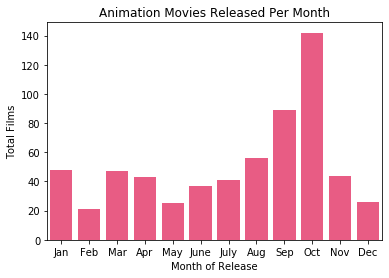

### Since we already discovered that Animation movies are less risky we wanted to discover when there was a gap in the market demand for them. Below you'll find the chart and code to find that info. 

185


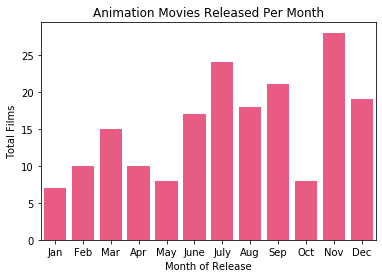

In [22]:

month = []
for movies in df_clean["release_year_month"]:
    if isinstance(movies, str):
        month.append(movies[5:7])
    else:
        month.append("00")
df_clean["month"] = month

df_watched = df_clean.loc[(df_clean["numvotes"] >= 284) & (df_clean["vote_count"] >= 25)]

movie_genres_by_month = df_watched.groupby(['month'])['genres'].sum()
movie_genre = []
for items in movie_genres_by_month.iteritems():
    movie_genre.append(items[1].count("Animation")) 
movie_genre_mon = pd.Series(movie_genre) 
movie_genre_mon = movie_genre_mon.rename({0: "Jan", 1:"Feb", 2:"Mar", 3:"Apr",4:"May",5:"June",6:"July", 7:"Aug", 8:"Sep", 9:"Oct", 10:"Nov", 11:"Dec"})
print(sum(movie_genre_mon))

genresreleases = sns.barplot(movie_genre_mon.index, movie_genre_mon.values, color="#ff457a")
genresreleases.setdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAX4AAAEWCAYAAABhffzLAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAfuklEQVR4nO3debgcVZnH8e+PRVkCCSFXDAhEEURACBhBBlQQREAUGBUHlUUYAyoiCjOD4oxxQRkHRB1QZF8UJAoMoCBgICg7YQtLQLbIFkKQsIRNiO/8cU6T4qa7b3ffVHfurd/nefrp6treU13db586VXVaEYGZmVXHEr0ugJmZdZcTv5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcU48Q9RkuZJeluXYh0n6T+7EWtRk3SnpK16XY4aSVtJeqTX5SiSFJLe3utydIukSZJ+2ety9JITf49JmipprqQ3trNcRIyIiAdKKM/ekq7qF2v/iPhuCbEm5aRzYL/xB+XxkwYbIyLWj4ipg11PkaSZkl7MP76PSzpV0ohFGWNxkT+fL+VtfVLSuZLGLqJ1753384/6jd8ljz91EcRY7H5oFwdO/D0kaRzwPiCAj/W0ML3zF2CvfuP2zOMXZx+NiBHAeGBj4Os9Lk+ZDsjbug4wCji63RVIWqrBpPuBT/WbPhT2/5DmxN9bewLXAafSL/nlWuSxkn4v6TlJ10taqzD9tcPzPO/PJF2ca2ZXS3qzpB/no4m7JW1cWPZQSffn9d4ladc8/p3AccDmeT1PF9b/vcLyn5d0n6SnJF0gadV+5dpf0r059rGS1OQ9uBFYTtL6efn1gWXz+OL7UTdmboY6st+850v6Wh6eKWnbPLxEYdv/JmmypNF52jKSfpnHPy3pRkmrNCk3ABHxOHAJ6QegFv+Nko6U9JCk2bmMy9ZbXtKqks6RNEfSg8WjH0mbSro2l2eWpGMkvSFPk6SjJT0h6RlJ0yVt0Ep8Sf+W1/eYpH0G2sbCtj4FnAMMGKdW05b0H5IeB05psNrHgduBD+flRgP/BFzQ7336mFKz3dNKRyHvLEybKemQ/B48I+nsvD+XBy4GVs2f53mFz+obJJ2evwN3SprQ6vswHDjx99aewK/y48N1Es3uwLeBlYD7gMObrGs34JvAGOBl4Frg5vz6t0DxcPp+0pHGyLz+X0oaGxEzgP2Ba3NT0qj+QSR9EPhBjjcW+Cvw636z7QS8B9goz/fhJuUGOIP0XkD6ATy9jZhnkmqMyvOuBGxXp0wABwK7AB8AVgXmAscW4o4EVgdWJr0PLw5QbiS9BdiBtH9q/ptUOx4PvB1YDfivOssuAVwI3Jbn2QY4SFLt/ZoPfJW0DzfP07+Yp20HvJ8FtfBPAX8bKL6k7YFDgA8BawPbDrSNhfKOAT4O3NLidr4ZGA2sCUxssurTWbD//wU4n/QZrsVdBzgLOAjoAy4CLqz9CGa7AdsDbwU2BPaOiOdJ++ax/HkeERGP5fk/RvqMjCL9yBzT2rswTESEHz14AFsCrwBj8uu7ga8Wpp8KnFh4vSNwd+F1AG8vzHtCYdqXgRmF1+8Cnm5SlluBnfPw3sBV/aafCnwvD58E/LAwbUTejnGFcm1ZmD4ZOLRB3EnAL4E1gIeApfPz6nn8pIFiAsrLvD9P+zxweWHemcC2eXgGsE1h2ti8nqWAfYBrgA1b2HczgXnAc3l7pwCj8jQBzwNrFebfHHgwD28FPJKHNwMe6rfurwOnNIh7EHBeHv4gqTnkvcAShXkGin8ycERh2jrFz1KdmFOBF4CngUdJlZS+Frfz78AyTd7HvYGrSEd4s0k/vNcBWwDfA07N8/0nMLmw3BK5LFsV9sdnC9N/CBzX//3u97n7Y+H1esCL3fz+9/rhGn/v7AVcGhFP5tdnsnBb9+OF4RdICa+R2YXhF+u8fm1ZSXtKujUfNj9NOnQf02K5VyXVuAGIiHmkmuZqHZabiHiIVGP+PnBvRDzcasxI39xfk46OAD5NSk71rAmcV9juGaRa9Sqko45LgF/nJpAfSlq6SbF3iYgVSIllXRa8f33AcsBNhTh/yOPrlWfV2nx53m/k8iBpHUm/UzqB/Gx+f8bk9+ByUi31WGC2pOMlrdhC/FWB4vv7VwZ2YESMiojVIuIzETGnxe2cExEvDbTyiHgR+D35iDUiru43S//9/4+8DR1/5urMv4wan4cYdpz4eyC3g+4GfCB/qR8nHdJvJGmjkmOvCZwAHACsHKk55w5SDQ5S7a+Zx0gJq7a+5UlNI48OsminAwfTr5mnxZhnAZ/I27YZqR26noeBHXISqz2WiYhHI+KViPh2RKxHamPeiQXNDw1FxJWkI6LaeYYnST+06xdijIx0crReeR7sV54VImLHPP3npCPBtSNiRdKPwmvnSyLipxHxbmB9Us3931qIP4t0RFWzxkDb2EAr29lO17+1/X9GnWn9979I29DKZ87dD9fhxN8bu5BqmuuR2kfHA+8E/kwLyWaQlid9GeYASPoc+WRdNht4S7/206Izgc9JGq90Cer3gesjYuYgy3U2qd16crsxI+KWvD0nApdExNMNYhwHHJ5/IJDUJ2nnPLy1pHdJWhJ4ltQENL/Fsv8Y+JCk8bk2egJwtKQ35XWvVmi3L7oBeDafAF1W0pKSNpD0njx9hVyWeZLWBb5QW1DSeyRtlo9KngdeAua3EH8ysLek9SQtB3yrxW18nTa3sxVXks47/G+daZOBj0jaJm/vwaRzANe0sN7ZwMqSRnZYrmHJib839iK14z4UEY/XHqRD98+UecgZEXcBR5FO/s4mtf8XD60vB+4EHpf0ZJ3lp5DaXM8h1R7XIp2QG2y5XoyIP+bD/k5inkU6UXlmkzA/IZ3Iu1TSc6T25M3ytDeTToI/S2oCupJ0nqGVss8h1VhrN7n9B6np6rrcRPNH4B11lpsPfJT0w/8gqRZ9IqmtG9JJ2E+TziWcQPpxrFkxj5tLagb5GwuOOhrGj4iLST9Ul+d5Lm9lGxtoaTtbEcmUSFcO9Z92D/BZ0o/Ck6T37KMR8fcW1ns36bPxQG6SWnWgZapAqYnUzMyqwjV+M7OKceI3M6sYJ34zs4px4jczq5ghccPCmDFjYty4cb0uhpnZkHLTTTc9GREL3Tw4JBL/uHHjmDZtWq+LYWY2pEiqe2e2m3rMzCrGid/MrGKc+M3MKsaJ38ysYpz4zcwqxonfzKxinPjNzCrGid/MrGKc+M3MKmZI3LlrZla22XscXsp6VznjsFLWOxiu8ZuZVYwTv5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcU48ZuZVYwTv5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcU48ZuZVYwTv5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcWUlvglrS7pCkkzJN0p6St5/CRJj0q6NT92LKsMZma2sDL/c/dV4OCIuFnSCsBNki7L046OiCNLjG1mZg2UlvgjYhYwKw8/J2kGsFpZ8czMrDVdaeOXNA7YGLg+jzpA0nRJJ0taqcEyEyVNkzRtzpw53SimmVkllJ74JY0AzgEOiohngZ8DawHjSUcER9VbLiKOj4gJETGhr6+v7GKamVVGqYlf0tKkpP+riDgXICJmR8T8iPgHcAKwaZllMDOz1yvzqh4BJwEzIuJHhfFjC7PtCtxRVhnMzGxhZV7VswWwB3C7pFvzuG8Au0saDwQwE9ivxDKYmVk/ZV7VcxWgOpMuKiummZkNzHfumplVTJlNPWaVMnuPw0tZ7ypnHFbKeq26XOM3M6sYJ34zs4px4jczqxgnfjOzinHiNzOrGCd+M7OKceI3M6sYJ34zs4px4jczqxgnfjOzinHiNzOrGCd+M7OKceI3M6sYJ34zs4px4jczqxgnfjOzinHiNzOrGCd+M7OKceI3M6sYJ34zs4px4jczq5ilel0AMxsaZu9xeCnrXeWMw0pZrzXmGr+ZWcU48ZuZVYwTv5lZxTjxm5lVTGmJX9Lqkq6QNEPSnZK+ksePlnSZpHvz80pllcHMzBZWZo3/VeDgiHgn8F7gS5LWAw4FpkTE2sCU/NrMzLqktMQfEbMi4uY8/BwwA1gN2Bk4Lc92GrBLWWUwM7OFdaWNX9I4YGPgemCViJgF6ccBeFODZSZKmiZp2pw5c7pRTDOzSig98UsaAZwDHBQRz7a6XEQcHxETImJCX19feQU0M6uYUhO/pKVJSf9XEXFuHj1b0tg8fSzwRJllMDOz1yvzqh4BJwEzIuJHhUkXAHvl4b2A88sqg5mZLazMvnq2APYAbpd0ax73DeAIYLKkfYGHgE+WWAYzM+untMQfEVcBajB5m7LimplZc75z18ysYtwts5lZD/Sym2vX+M3MKsaJ38ysYpz4zcwqxonfzKxinPjNzCrGid/MrGIGTPySDpC0Yh7+haQbJPkGLDOzIaqV6/gnRsQxkrYj9af/BeB44N2llszMmurldeA2tLXS1BP5eQfglIi4qcXlzMxsMdRKAr9N0kXAR4GLc//6McAyZma2mGqlqedzpGad+yLiBUljgH3LLZaZmZVlwMQfEfMlzQPeK6k4/y3lFcvMzMoyYOKXdAIwAbgL+EceHaQ/VDEzsyGmlaaeLYH1IsLt+mZmw0Arif96YB3gnpLLYrZIlXW5I/iSRxvaWkn8JwHXS3oUeJn0r1oREZuUWjIzMytFK4n/ZGAf4HYWtPGbmdkQ1Urifzgizi29JGZm1hWtJP67JJ0OXEhq6gEgInxVj5nZENRK4h+Znz9WGOfLOc3MhqhWbuDaoxsFMTOz7miY+CUdTZM+eSLia6WUyMzMStWsxn9H10phZmZd0zDxR8RJ3SyImZl1R7OmnqMi4mBJ51GnySci/rnUkpmZWSmaNfWcnZ+P6UZBzMysO5ol/kcBImJKJyuWdDKwE/BERGyQx00CPg/MybN9IyIu6mT9ZmbWmWb/wHVhbUDS5A7WfSqwfZ3xR0fE+Pxw0jcz67JmiV+F4bXbXXFE/Al4qu0SmZlZqZo19USD4cE6QNKewDTg4IiYW28mSROBiQBrrLHGIgy/eCurK2F3I2xmNc1q/BtJekrSXGDDPPyUpLmSOq3J/xxYCxgPzAKOajRjRBwfERMiYkJfX1+H4czMrL9mNf43LOpgETG7Npz/0vF3izqGmZk11+wGrvmLOpiksRExK7/cFd8dbGbWda30ztkRSWcBWwFjJD0CfAvYStJ40jmDmcB+ZcU3M7P6Skv8EbF7ndHuBsLMrMeandw1M7NhqFlfPXOpfxln7c/WR5dWKjMzK02zpp4xXSuFmZl1TctX9UgaDSxTGPVYWYUyM7PyDNjGL+kjkv4CPAJcn58vL7tgZmZWjlZO7h4ObAHcExGrAx8GppZZKDMzK08rif/ViJgDLCFJEXEZsEnJ5TIzs5K0ch3/M5KWB64CTpf0BPCPcotlZmZlaaXGvwvwEnAQqYnnUdIfrJiZ2RDUSuL/ekTMj4hXIuKkiPgR8LWyC2ZmZuVoJfHX+xetjyzqgpiZWXc0u3N3P2B/YB1JNxcmrUD6ExUzMxuCmp3cnQxMAX4AHFoY/1xEPFFqqczMrDTN7tydC8wFPilpA2DLPOnPgBO/mdkQ1cqdu18i1f7XyI/Jkr5YdsHMzKwcrVzHvx+waUTMA5D0feAa4GdlFszMzMrRylU9Al4pvH4ljzMzsyGo2VU9S0XEq8AZwHWSzsmTdgVO60bhzMxs0WvW1HMDsElE/FDSFcD7SDX9/SPixq6UzszMFrlmif+15pyc6J3szcyGgWaJv09Sw64ZctcNZmY2xDRL/EsCI/CJXDOzYaVZ4p8VEd/pWknMzKwrml3O6Zq+mdkw1Czxb9O1UpiZWdc0TPwR8VQ3C2JmZt3Ryp27ZmY2jDjxm5lVTGmJX9LJkp6QdEdh3GhJl0m6Nz+vVFZ8MzOrr8wa/6ks/LeNhwJTImJt0p+8HNp/ITMzK1dpiT8i/gT0P0G8Mws6eDsN2KWs+GZmVl8r/fEvSqtExCyAiJgl6U2NZpQ0EZgIsMYaa3SpeAubvcfhpax3lTMOK2W97Shr22Dx2D4zq2+xPbkbEcdHxISImNDX19fr4piZDRvdTvyzJY0FyM/+714zsy7rduK/ANgrD+8FnN/l+GZmlVfm5ZxnAdcC75D0iKR9gSOAD0m6F/hQfm1mZl1U2sndiNi9wST3AWRm1kOL7cldMzMrhxO/mVnFOPGbmVWME7+ZWcU48ZuZVYwTv5lZxTjxm5lVjBO/mVnFOPGbmVVMt7tltgpzN9DWjuHcJXqvucZvZlYxTvxmZhXjxG9mVjFO/GZmFePEb2ZWMU78ZmYVM+Qu5/QlXmZmg+Mav5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcU48ZuZVYwTv5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcX0pK8eSTOB54D5wKsRMaEX5TAzq6JedtK2dUQ82cP4ZmaV5KYeM7OK6VXiD+BSSTdJmlhvBkkTJU2TNG3OnDldLp6Z2fDVq8S/RURsAuwAfEnS+/vPEBHHR8SEiJjQ19fX/RKamQ1TPUn8EfFYfn4COA/YtBflMDOroq4nfknLS1qhNgxsB9zR7XKYmVVVL67qWQU4T1It/pkR8YcelMPMrJK6nvgj4gFgo27HNTOzxJdzmplVjBO/mVnFOPGbmVWME7+ZWcU48ZuZVYwTv5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcU48ZuZVYwTv5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcU48ZuZVYwTv5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcU48ZuZVYwTv5lZxTjxm5lVjBO/mVnFOPGbmVWME7+ZWcX0JPFL2l7SPZLuk3RoL8pgZlZVXU/8kpYEjgV2ANYDdpe0XrfLYWZWVb2o8W8K3BcRD0TE34FfAzv3oBxmZpWkiOhuQOkTwPYR8a/59R7AZhFxQL/5JgIT88t3APd0EG4M8OQgiut41Yk3nLfN8aobb82I6Os/cqnBl6dtqjNuoV+fiDgeOH5QgaRpETFhMOtwvGrEG87b5niO118vmnoeAVYvvH4L8FgPymFmVkm9SPw3AmtLequkNwD/AlzQg3KYmVVS15t6IuJVSQcAlwBLAidHxJ0lhRtUU5HjVSrecN42x3O81+n6yV0zM+st37lrZlYxTvxmZhUzLBK/pHldijNf0q2Fx7gm824l6XeDiBWSzii8XkrSnMGss8W4u+bY65YYo6vb1q3PR7txJU2VtEgu0evGfusX7zBJd0qanr8Lm3Uh5lsknS/pXkn3S/pJvkCk0fwHSVqugzgh6ajC60MkTeqw2K3Eq+WVOyXdJulrkkrNzcMi8XfRixExvvCYWWKs54ENJC2bX38IeLSdFUjq5OT97sBVpKut2om1ZBuzD3rbbCEd7bdOSNoc2AnYJCI2BLYFHi45poBzgf+LiLWBdYARwOFNFjsIaDvxAy8D/yxpTAfLdqKWV9YnfRd2BL5VZsBhk/gljZA0RdLNkm6XtHMeP07SDEkn5F/USwsJZ1HEXVLS/0i6Mdd+9itMXlHSeZLuknRcB7/iFwMfycO7A2cV4m4q6RpJt+Tnd+Txe0v6jaQLgUvb3JYRwBbAvuQEko9c/lRvOyTNk/QdSdcDm3dh2/4saXxhvqslbdjitr3uCEzSMZL2zsMzJX278NlZN49fXtLJed/eUvtMtaNZ3MK4fSUdXXj9eUk/aiNGo/3WaHt3lHS3pKsk/bSDI62xwJMR8TJARDwZEY9JerekKyXdJOkSSWNzvKmSfpz35R2SNm0zHsAHgZci4pQccz7wVWCfvJ+OzPtuuqQvSzoQWBW4QtIVbcZ6lXQVzVf7T5C0Zs4z0/PzGpJG5s9Q7XuxnKSHJS3d7kZGxBOkHgsOUNIwv0j697zNt0k6ot1AQ/4BzCNdmrpifj0GuI90l/C4vCPH52mTgc92GGc+cGt+nJfHTQS+mYffCEwD3gpsBbwEvI102eplwCfa3KYNgd8Cy+SYWwG/y9NXBJbKw9sC5+ThvUk3yY3uYPs+C5yUh68BNmm2HaQ7rnfrcH91sm17AT/Ow+sA09qI99r687hjgL3z8Ezgy3n4i8CJefj7tc8KMAr4C7B8m9vZLO5UYAKwPHA/sHThvX/XIthvC8XN7/fDwFvz+LOK87UYb0TeZ38BfgZ8AFg6x+7L83yKdKl2bTtPyMPvB+7o4DNzIHB0nfG3AF8Bzil8ZkYX9uuYDj+fK+blRwKHAJPytAuBvfLwPqQjEIDzga0L235iO/HqjJsLrELj/LJDfr+XK25zq49hU+MnJfnvS5oO/BFYjfTGATwYEbfm4ZtIPwadKDb17JrHbQfsKelW4HpgZWDtPO2GSJ3RzSd9wbZsJ1hETM9l3R24qN/kkcBvJN0BHA2sX5h2WUQ81U6sbHdSp3nk593zcKPtmE/6wrWtw237DbBTrkntA5zaSewGzs3Pxc/HdsChed9OJSXNNRZhTAAi4nngctK2rUv6Abi9jVU02m/1rAs8EBEP5tdnNZm3UXnnAe8mJaU5wNnAfsAGwGX5/fom6a78mrPysn8iHQmPajOsqNO1Sx7/fuC4iHg1x+jks/86EfEscDrpB6doc+DMPHwGC74LZ5MSPqSjrrMHWYRa1zaN8su2wCkR8UIub1vb3Iu+esryGaAPeHdEvCJpJumLCqnNrmY+sMiaekg76MsRccnrRkpbsfAHtZObJi4AjiTV4FYujP8ucEVE7Kp0knlqYdrz7QaRtDLpcHoDSUGq3QcpKTfajpfyj0Gn2tq2iHhB0mWk3lx3I9WWW/Uqr2/aXKbf9NpnZD4LvhcCPh4RnXQQ2GrcmhOBbwB3A6e0uvIm++2CBnHr9ZXVtrzfpwJTJd0OfAm4MyIaNfkN9rtwJ/Dx4ghJK5K6f3mgg/W14sfAzTTfH7W4FwA/kDSa9KN4eadBJb2N9Dl8gsb5ZXsGsc3DqcY/EngiJ/2tgTW7FPcS4Au19jxJ60haPk/bVKlriiVItYGrOlj/ycB36tQAR7LghOjeHay3v08Ap0fEmhExLiJWBx4k1WgWxXbU08m2nQj8FLixzVrOX4H1JL1R0khgmxaWuQT4siQBSNq4jXhtxY2I60lJ7NO0VwtvtN9oEPdu4G1acEXap2iTpHdIWrswajwwA+hTOvGLpKUlFY9CP5XHbwk8ExHPtBl2CrCcpD3zepYEjiId9V0K7K98MUNOvgDPASu0Gec1+fM1mXTupOYaFpxA/wz5u5CPgm4AfkJqOuuoQiSpDzgOOCZSG06j/HIp6fzGcnn86EbrrGfIJ/68s18GfgVMkDSNtEPu7lIRTgTuAm7OTRO/YEGN8VrgCOAO0pfxvHZXHhGPRMRP6kz6IamGcTWpljdYu7Nw+c4hJaJBb0c9nWxbRNwEPEuLteLa5yMiHiZ9iaeTPiu3tLD4d0lt19Pzvv1uKzEHEXcycHVEzG01Ds3320JxI+JF0nmMP0i6CpgNtJuERwCnKZ3sn076Q6X/Iv0I/bek20jnAP6psMxcSdeQktq+/Vc4kJwEdwU+Kele0vmFl0hHSScCD5H202152yGdoL24g5O7RUeRzhnWHAh8Lm/3HqTzCzVnk863tNvMs6zy5ZykZupLgW/naXXzS0T8gXSUMS03Ax3STsAh32WDpI1IJ446uVLABpCbrA6JiJ16XRYASauSmhjWjYh/tDB/Tz4fncRVurrm6IiYUl7J0lVAETEvH8kcC9wbEUcPtNwg4k0lfYamlRXD2jOka/yS9icdFn+z12Wx8uXD/OuBw1pM+j35fLQbV9IoSX8hXTxQatLPPp9riXeSmtV+0YWYthgZ8jV+MzNrz5Cu8ZuZWfuc+M3MKsaJ38ysYpz4bbGkRdyDZz6B+sXC68H2nrpuvgTvFklr9Zs2Uwv6jblS0oD3lORlutUpmFWcE78trhZ1D56jSNevLyq7AOdHxMYRcX+d6VtH6rlyKr7qzBYzTvy2OGvWg+doSf+Xa9XXKffSKWmSUo+aUyU9oNRLI6Qb0NbKtfT/yeNGSPqtUk+Vv6rdoVskaXxe/3SlHkpXkrQjqcvff23h5qBrSf1G1db3WUk35HL8QnW6s240j6SfS5qm1MvstwvzH1G7mUrSkXlcn6RzlHp1vFHSFgOU06qk3Z7r/PCjGw8G7sHzf4Fv5eEPArfm4Umk2+rfSLrj8m+ku2/HUegVMq/rGVJHYkuQEvSWdcoxHfhAHv4OC3oHnUS6Kale2WeSe4Uk9fcyMQ+/k9S7Y60Xzp8BexaXGWCeWq+TS5KOJDYERgP3sODS7FH5+cza9pA6lpvR633qx+LzGE6dtNkwExHTc58y9Xrw3JLcaVdEXC5pZaU+aQB+H6mv+JclPcGCXlr7uyEiHgHINzSNo9APUV7fqIi4Mo86jdRDaCuukLQKqaOtWlPPNqQOvG7MBxfL5ulFzebZTdJEUpcgY0ldJdxF6rrgREm/B2rnLbYl9dVTW++KklaIiOdaLL8NY078trhr1INnvV4ma3cj9u+NtdHnvNX5OrE16TzFqaQjha+RynxaRHy9yXJ155H0VlJ/LO+JiLmSTgWWiYhXlf7YZBtS52EHkI6AlgA2j9Q3j9nruI3fFneNevD8E6kzvlp/Qk9G6kO9kbZ7aozUg+RcSe/Lo/YArmyySP/lXySdC9gz9544BfiEpDflco+uc8VPo3lWJP2QPJOPJHbI00cAIyPiohyr9g9ll5J+BMjzjccsc43fFmu5KaZeD56TgFNyL4kvkP6dq9l6/qb0V413kE4a/77FIuwFHKfU/e0DwOdaLXuOO0vSWcCXIuK7kr4JXKrUxfUrpH7s/1qY/65680TEdZJuIfWv8wBwdV5kBeB8ScuQjhZqfxd4IHBsfn+WIv1Q7t9O2W34cl89ZmYV46YeM7OKceI3M6sYJ34zs4px4jczqxgnfjOzinHiNzOrGCd+M7OK+X9ERgDiy3OoQwAAAABJRU5ErkJggg==(xlabel='Month of Release', ylabel='Total Films')
genresreleases.set_title("Animation Movies Released Per Month")
plt.show()

### October, Jan, and May have the least animation movies to released (and therefore less competition). 

Then to narror down our decision further, we looked at when more people were already seeing movies. 

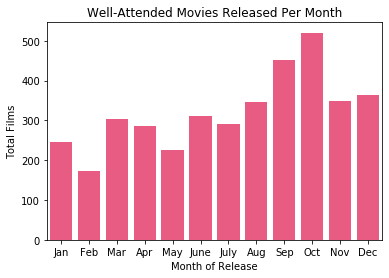

In [24]:
total_movies_month = df_watched["month"].value_counts()
total_movies_month = total_movies_month.sort_index()
#Renaming X-Axis for legibility
total_movies_month = total_movies_month.rename({"01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr", "05":"May", "06":"June", "07":"July","08":"Aug", "09": "Sep", "10":"Oct", "11":"Nov", "12":"Dec"})
ax = sns.barplot(total_movies_month.index, total_movies_month.values, color="#ff457a")
ax.set(xlabel='Month of Release', ylabel='Total Films')
ax.set_title("Well-Attended Movies Released Per Month")
plt.show()

### So with October being the busiest time of the year for movies, we concluded it would be good to release an under-represented genre (Animation) during that time as people were likely already interested in seeing movies during that month. 